In [1]:
!git clone https://github.com/ksideks/UCSD.git

fatal: docelowa ścieżka „UCSD” już istnieje i nie jest pustym katalogiem.


In [2]:
!pip install keras-layer-normalization

In [3]:
TestVideoFile = {}
TestVideoFile[1] = range(59,152)
TestVideoFile[2] = range(49,175)
TestVideoFile[3] = range(90,200)
TestVideoFile[4] = range(30,168)
TestVideoFile[5] = list(range(4,90)) + list(range(139,200))
TestVideoFile[6] = list(range(0,100)) + list(range(109,200))
TestVideoFile[7] = range(0,175)
TestVideoFile[8] = range(0,94)
TestVideoFile[9] = range(0,48)
TestVideoFile[10] = range(0,140)
TestVideoFile[11] = range(69,165)
TestVideoFile[12] = range(130,200)
TestVideoFile[13] = range(0,156)
TestVideoFile[14] = range(3,198)  # 0 200
TestVideoFile[15] = range(137,200)
TestVideoFile[16] = range(122,200)
TestVideoFile[17] = range(0,47)
TestVideoFile[18] = range(53,120)
TestVideoFile[19] = range(63,138)
TestVideoFile[20] = range(44,175)
TestVideoFile[21] = range(30,200)
TestVideoFile[22] = range(16,107)
TestVideoFile[23] = range(8,165)
TestVideoFile[24] = range(49,171)
TestVideoFile[25] = range(39,135)
TestVideoFile[26] = range(77,144)
TestVideoFile[27] = range(9,122)
TestVideoFile[28] = range(104,200)
TestVideoFile[29] = list(range(0,15)) + list(range(44,113))
TestVideoFile[30] = range(174,200)
TestVideoFile[31] = range(0,180)
TestVideoFile[32] = list(range(0,52)) + list(range(64,115))
TestVideoFile[33] = range(4,165)
TestVideoFile[34] = range(0,121)
TestVideoFile[35] = range(85,200)
TestVideoFile[36] = range(14,108)

In [4]:
#imports
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve

import keras
import tensorflow as tf 
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


2021-11-10 19:47:51.170952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-10 19:47:51.170997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
class Config:
  DATASET_PATH ="UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  TEST_PATH ="UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
  SINGLE_TEST_PATH = "UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
  SINGLE_TEST_VIDEO_FILE = 1
  BATCH_SIZE =  32
  EPOCHS = 50
  MODEL_PATH = "UCSD/model.hdf5"
  THRESHOLD = 0.95

In [6]:
def get_clips_by_step(step, frames_list, sequence_size):
   
    #data pre-processing, one volume has 10 clips, with different steps (1;2;3)
    volumes = []
    size = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 227, 227, 1))
    cnt = 0
    for start in range(0, step):
        for i in range(start, size, step):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                volumes.append(np.copy(clip))
                cnt = 0
    return volumes


def get_training_set():
    clips = []
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((227, 227))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            for stride in range(1, 3):
                clips.extend(get_clips_by_step(step=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [7]:
def get_model(reload_model=True): 
   
    #model is already saved, there's posibility to retrain it, but not until there's more memory RAM
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})

    #adding print checkpoints to see if model works
    print("starting training")
    training_set = get_training_set()
    training_set = np.array(training_set)
    print("got training set")

    training_set = training_set.reshape(-1,10,227,227,1)

    seq = Sequential() 

    #AUTOENCODER --> spatial part
    
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="valid", activation=None,), batch_input_shape=(None, 10, 227, 227, 1))) #resizing to 227, 227
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="valid", activation=None,)))
    seq.add(LayerNormalization())

    
    # Convolutional Long-short term memory --> temporal part
    seq.add(ConvLSTM2D(64, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    # AUTODECODER --> spatial part  

    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=2, padding="valid", activation=None,)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(1, (11, 11), strides=4, padding="valid", activation=None,)))
    seq.add(LayerNormalization())
    #seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))  

    print(seq.summary())  # SUMMARY Should be visible /seq.summary()


    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3)) #, decay=1e-5, epsilon=1e-6)) #no decay and no epsilon #changing learning rate --> 1e-3; lr=1e-4; 1e-3 etc.
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [8]:
def get_single_test():
    size = 200
    test = np.zeros(shape=(size, 227, 227, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((227, 227))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [9]:
def evaluate(reload_model=False):
    model = get_model(reload_model) #get_model(True) ->to retrain the model
    print("got model")
    test = get_single_test()
    print(test.shape)
    size = test.shape[0] - 10 + 1
    sequences = np.zeros((size, 10, 227, 227, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, size):
        clip = np.zeros((10, 227, 227, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)

    #caluclating the Eculidean distance/norm2
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,size)])

    #anomaly score as = sa
    anomaly_score = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)

    #Regularity score -> sr
    regularity_score = 1.0 - anomaly_score

    # plot the regularity scores vs frames
    plt.plot(regularity_score)
    plt.ylabel('regularity score(t)')
    plt.xlabel('frame t')
    plt.show()

    return regularity_score

starting training
got training set


2021-11-10 19:48:11.026840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-10 19:48:11.026896: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-10 19:48:11.026928: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml): /proc/driver/nvidia/version does not exist
2021-11-10 19:48:11.027374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 55, 55, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 55, 55, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 26, 26, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 26, 26, 64)   128       
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 26, 26, 64)    2

/home/user/notebook/jupyterenv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
43/43 [==============================] - 492s 11s/step - loss: 0.1657
Epoch 2/50
43/43 [==============================] - 478s 11s/step - loss: 0.1382
Epoch 3/50
43/43 [==============================] - 484s 11s/step - loss: 0.1155
Epoch 4/50
43/43 [==============================] - 480s 11s/step - loss: 0.0971
Epoch 5/50
43/43 [==============================] - 490s 11s/step - loss: 0.0825
Epoch 6/50
43/43 [==============================] - 474s 11s/step - loss: 0.0711
Epoch 7/50
43/43 [==============================] - 483s 11s/step - loss: 0.0624
Epoch 8/50
43/43 [==============================] - 470s 11s/step - loss: 0.0559
Epoch 9/50
43/43 [==============================] - 482s 11s/step - loss: 0.0511
Epoch 10/50
43/43 [==============================] - 474s 11s/step - loss: 0.0477
Epoch 11/50
43/43 [==============================] - 477s 11s/step - loss: 0.0453
Epoch 12/50
43/43 [==============================] - 477s 11s/step - loss: 0.0437
Epoch 13/50
43/43 [======

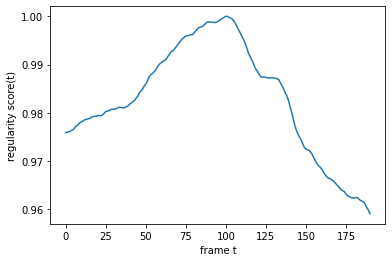

In [10]:
pr = evaluate(reload_model=True)  #checking for one video

AUC:  0.01492209787140662
EER:  0.946236559139785
EER THRESHOLD:  0.9835342593082625
Optimal threshold value is: 2.0


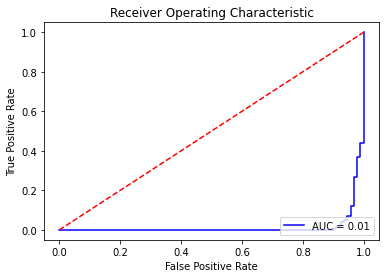

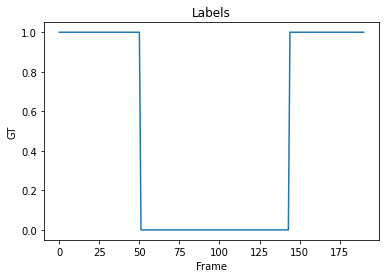

(0.01492209787140662, 0.946236559139785)

In [11]:
def plotROC(pr):
  y_pred = pr
  y_test = [1 for element in range(0, 200)]

  for i in TestVideoFile[Config.SINGLE_TEST_VIDEO_FILE]:
    y_test[i] = 0

  y_test = y_test[8:199] #testing with different removals to match number of regularity scores #different kinds still vary in 77%

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  fnr = 1 - tpr
  auc = metrics.roc_auc_score(y_test, y_pred)

  eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  optimal = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal]


  #print("FPR: ", fpr)
  #print("TPR: ", tpr)
  #print("THRESHOLDS", thresholds)
  print("AUC: ", auc)
  print("EER: ", eer)
  print("EER THRESHOLD: ", eer_threshold)
  print("Optimal threshold value is:", optimal_threshold)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')  
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  plt.plot(y_test)
  plt.title('Labels')  #labels(flags, 0-1) 
  plt.ylabel('GT')
  plt.xlabel('Frame')
  plt.show()

  return auc, eer

plotROC(pr)


PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001
GT:  1
got model
(200, 227, 227, 1)
got data


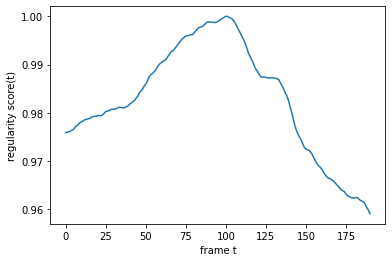

AUC:  0.01492209787140662
EER:  0.946236559139785
EER THRESHOLD:  0.9835342593082625
Optimal threshold value is: 2.0


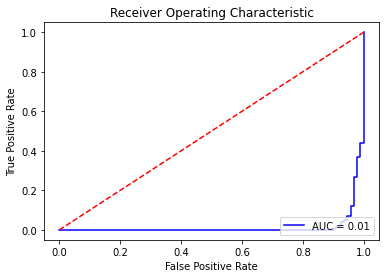

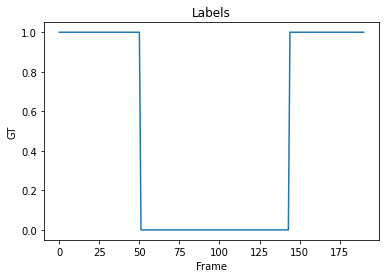

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test002
GT:  2
got model
(200, 227, 227, 1)
got data


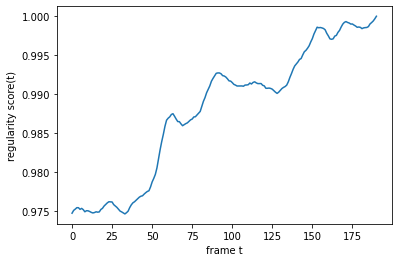

AUC:  0.36691086691086694
EER:  1.0
EER THRESHOLD:  0.9765661355120089
Optimal threshold value is: 0.9981894548688542


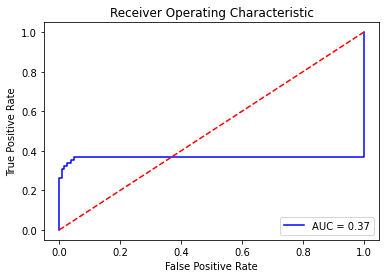

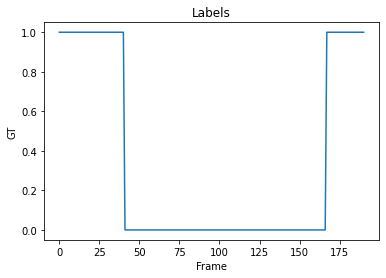

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test003
GT:  3
got model
(200, 227, 227, 1)
got data


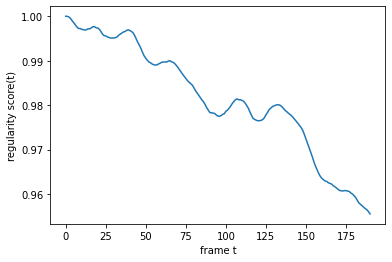

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.9832831117613453
Optimal threshold value is: 0.9832831117613453


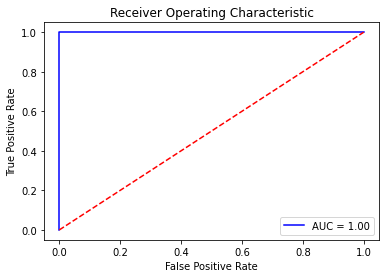

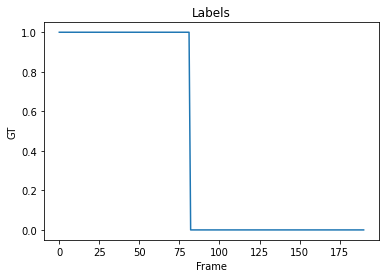

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004
GT:  4
got model
(200, 227, 227, 1)
got data


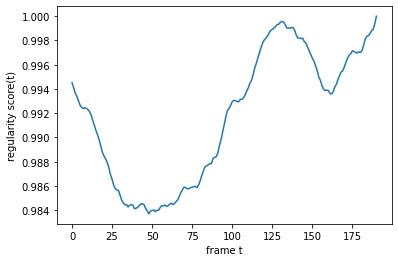

AUC:  0.6808859721082855
EER:  0.3695652173913043
EER THRESHOLD:  0.9935879839434365
Optimal threshold value is: 0.9884600386638904


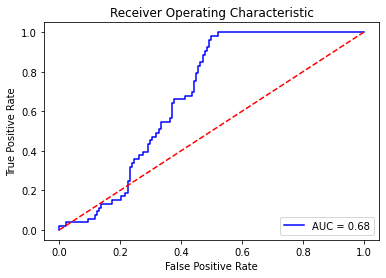

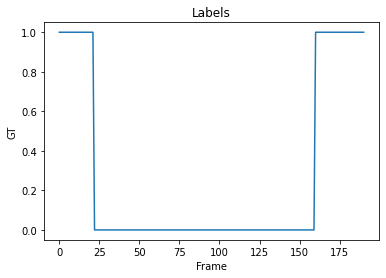

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005
GT:  5
got model
(200, 227, 227, 1)
got data


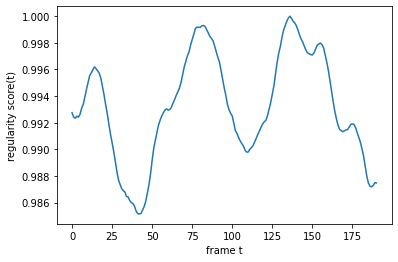

AUC:  0.524719747053751
EER:  0.5
EER THRESHOLD:  0.992992553386964
Optimal threshold value is: 0.9897817352494181


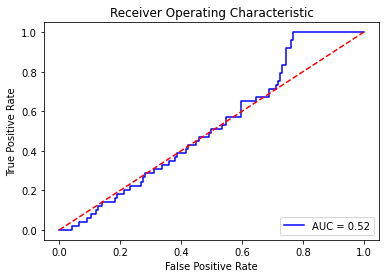

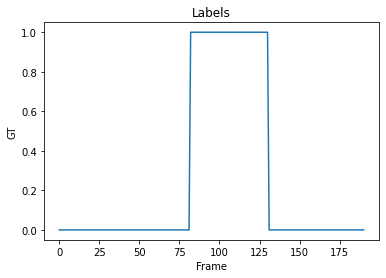

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test006
GT:  6
got model
(200, 227, 227, 1)
got data


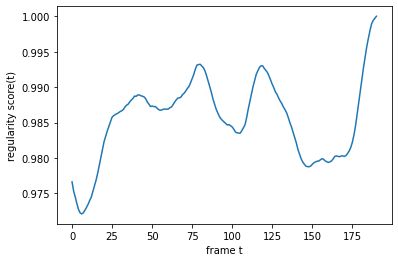

AUC:  0.40293040293040294
EER:  0.5934065934065934
EER THRESHOLD:  0.9850714971400839
Optimal threshold value is: 0.984377318730777


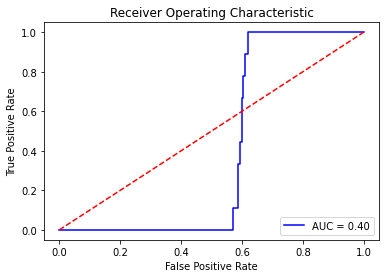

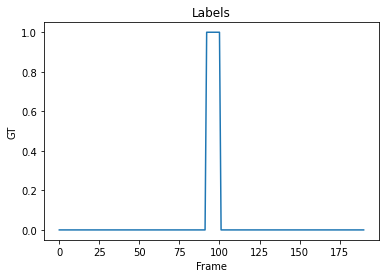

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test007
GT:  7
got model
(200, 227, 227, 1)
got data


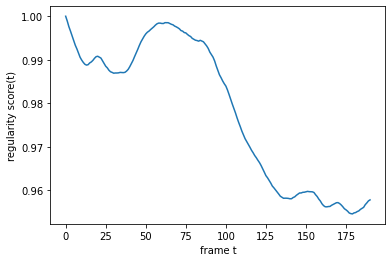

AUC:  0.01771457085828343
EER:  0.9520958083832335
EER THRESHOLD:  0.9575469374729314
Optimal threshold value is: 2.0


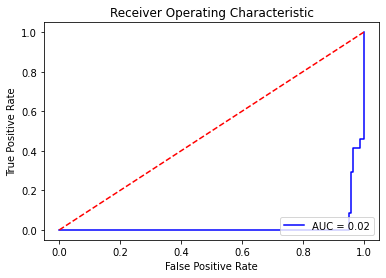

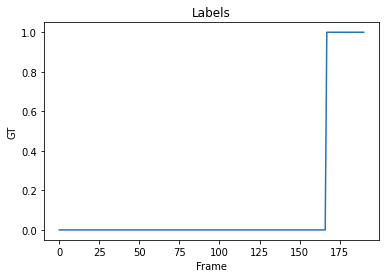

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test008
GT:  8
got model
(200, 227, 227, 1)
got data


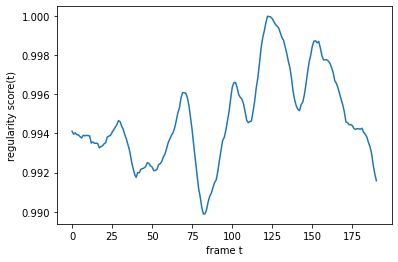

AUC:  0.8401993355481728
EER:  0.19767441860465115
EER THRESHOLD:  0.9942065413785959
Optimal threshold value is: 0.9942228813400523


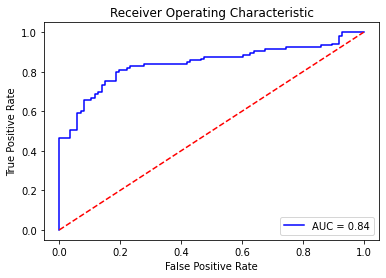

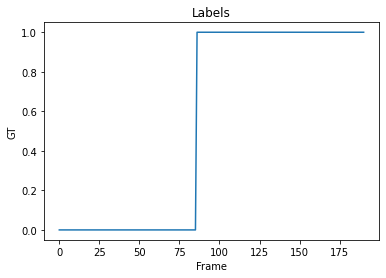

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test009
GT:  9
got model
(200, 227, 227, 1)
got data


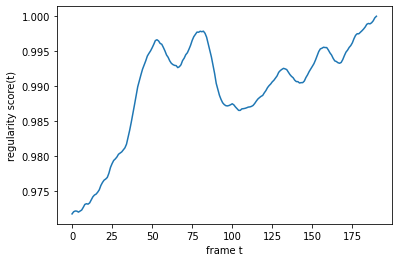

AUC:  0.9971854304635761
EER:  0.025
EER THRESHOLD:  0.9865614367290209
Optimal threshold value is: 0.9865614367290209


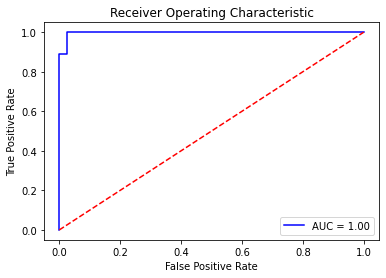

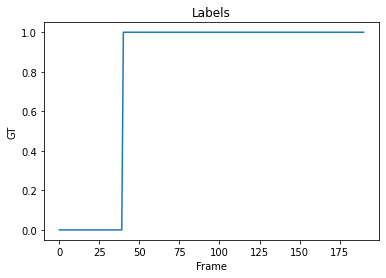

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test010
GT:  10
got model
(200, 227, 227, 1)
got data


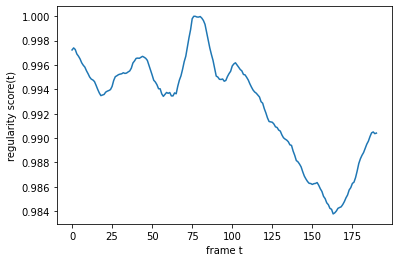

AUC:  0.0005136106831022081
EER:  0.9924242424242424
EER THRESHOLD:  0.9905735379262769
Optimal threshold value is: 2.0


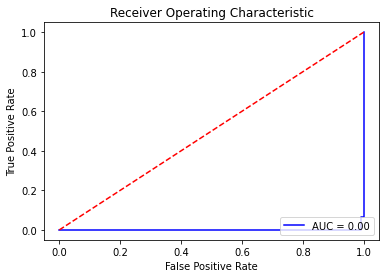

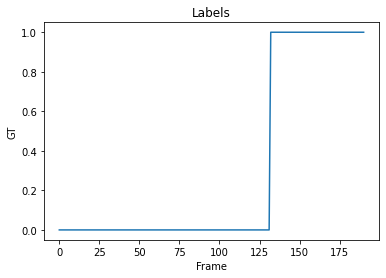

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test011
GT:  11
got model
(200, 227, 227, 1)
got data


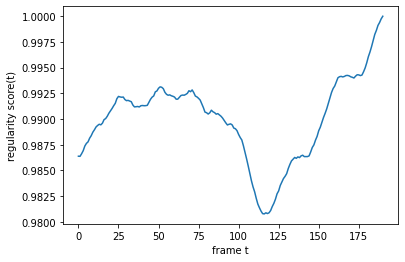

AUC:  0.8461622807017544
EER:  0.21875
EER THRESHOLD:  0.9908593848831139
Optimal threshold value is: 0.9910252394932282


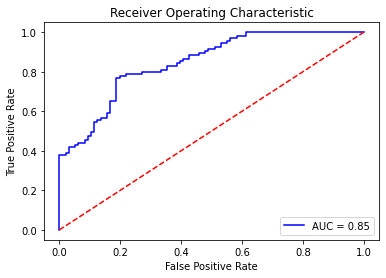

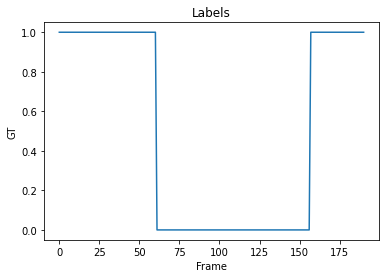

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test012
GT:  12
got model
(200, 227, 227, 1)
got data


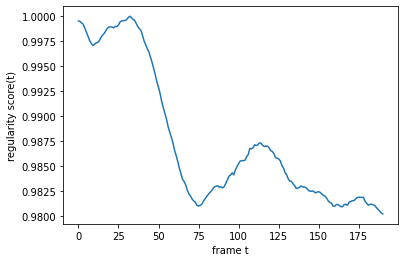

AUC:  0.8910667617011166
EER:  0.18840579710144928
EER THRESHOLD:  0.9830369514753164
Optimal threshold value is: 0.9836363992900877


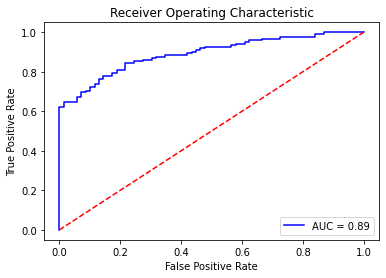

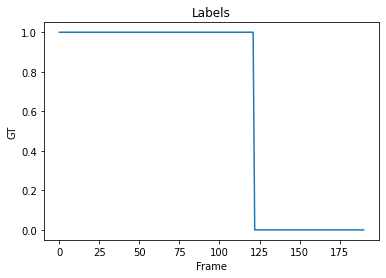

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test013
GT:  13
got model
(200, 227, 227, 1)
got data


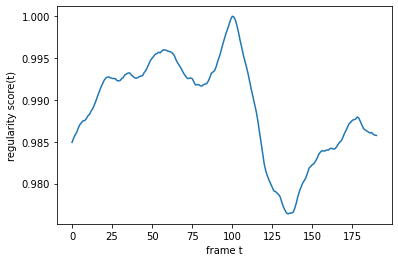

AUC:  0.21935889377749843
EER:  0.7635135135135135
EER THRESHOLD:  0.9866933152347778
Optimal threshold value is: 0.9818682193562874


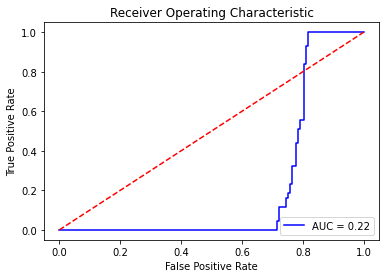

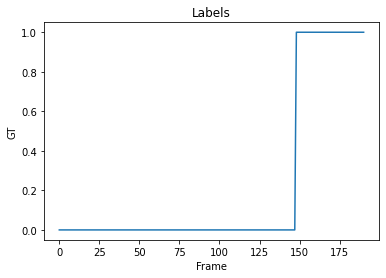

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014
GT:  14
got model
(200, 227, 227, 1)
got data


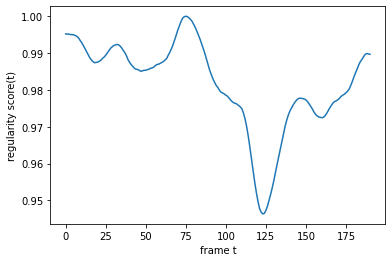

AUC:  0.7315789473684211
EER:  0.26842105263157895
EER THRESHOLD:  0.9896666297555512
Optimal threshold value is: 0.9896666297555512


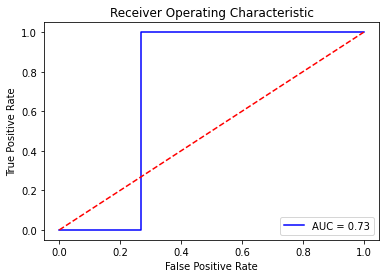

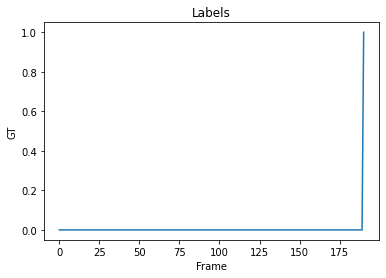

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test015
GT:  15
got model
(200, 227, 227, 1)
got data


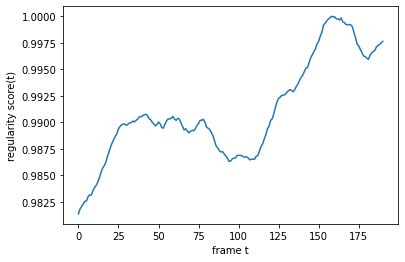

AUC:  0.0
EER:  1.0
EER THRESHOLD:  0.9926132559432149
Optimal threshold value is: 2.0


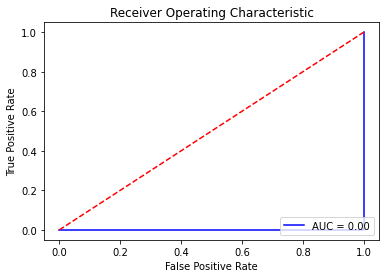

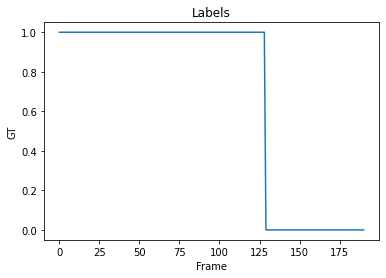

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test016
GT:  16
got model
(200, 227, 227, 1)
got data


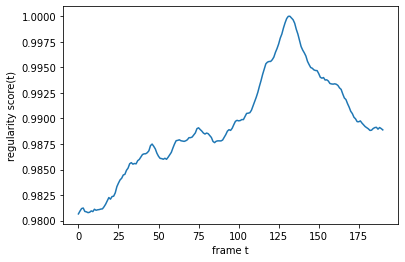

AUC:  0.04146730462519936
EER:  0.8311688311688312
EER THRESHOLD:  0.9893914217536139
Optimal threshold value is: 2.0


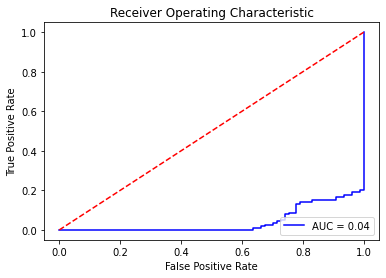

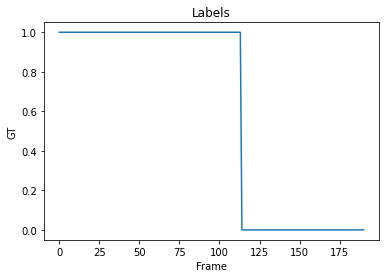

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test018
GT:  18
got model
(200, 227, 227, 1)
got data


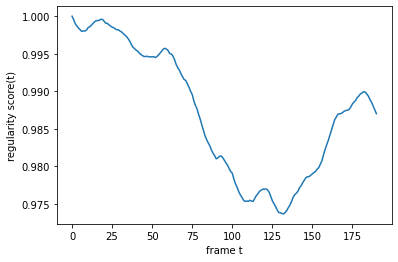

AUC:  0.5285267212325471
EER:  0.5074626865671642
EER THRESHOLD:  0.9876727939531719
Optimal threshold value is: 0.9958917549340376


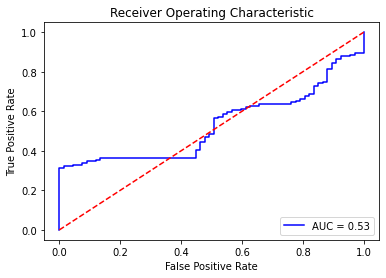

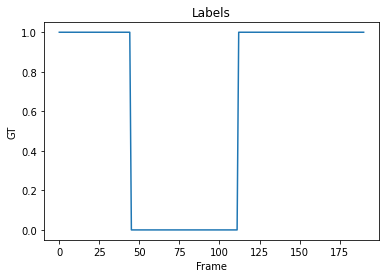

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019
GT:  19
got model
(200, 227, 227, 1)
got data


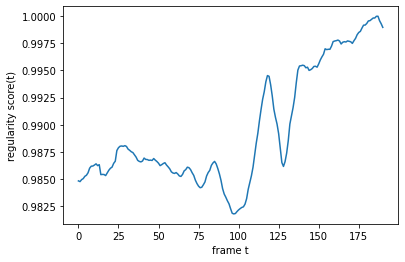

AUC:  0.834367816091954
EER:  0.25333333333333335
EER THRESHOLD:  0.9865940753007022
Optimal threshold value is: 0.9861698738756182


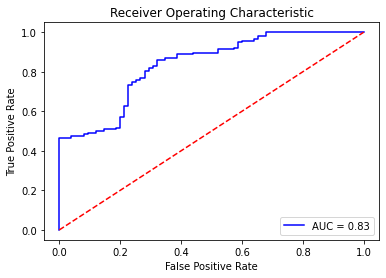

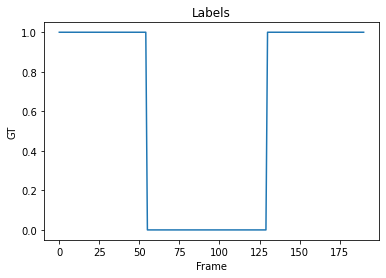

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test020
GT:  20
got model
(200, 227, 227, 1)
got data


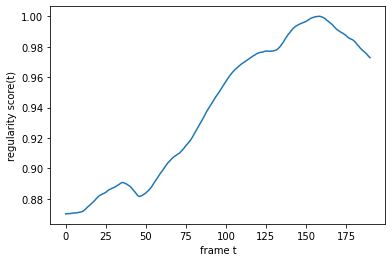

AUC:  0.3212468193384224
EER:  0.3893129770992366
EER THRESHOLD:  0.9727222086574338
Optimal threshold value is: 0.9778758299170154


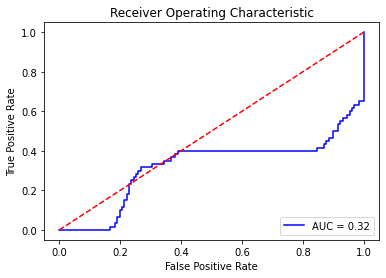

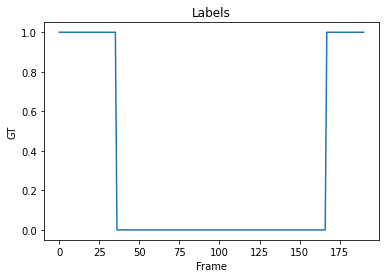

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test021
GT:  21
got model
(200, 227, 227, 1)
got data


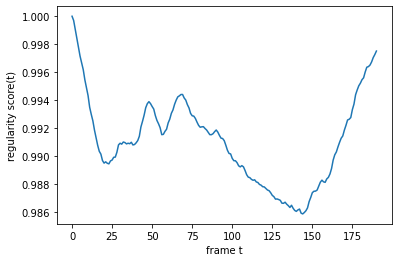

AUC:  0.7592791823561054
EER:  0.35502958579881655
EER THRESHOLD:  0.9918657316418088
Optimal threshold value is: 0.9943260540056195


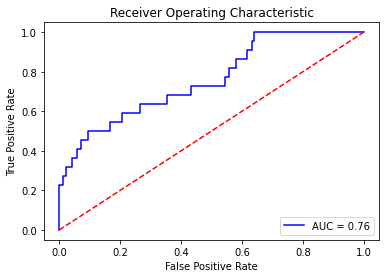

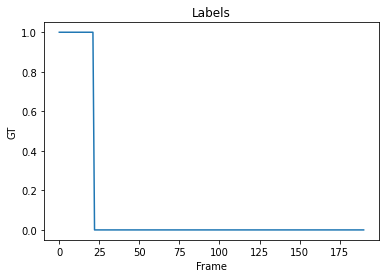

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test022
GT:  22
got model
(200, 227, 227, 1)
got data


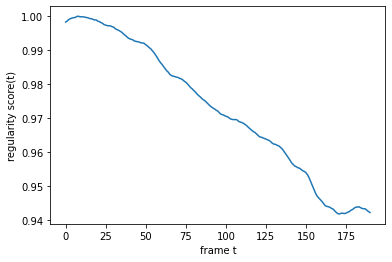

AUC:  0.07307692307692308
EER:  1.0
EER THRESHOLD:  0.9709700642441029
Optimal threshold value is: 2.0


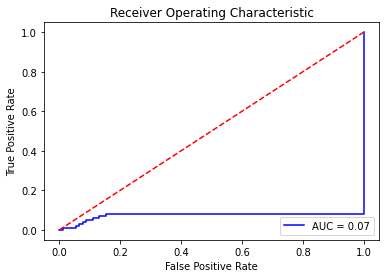

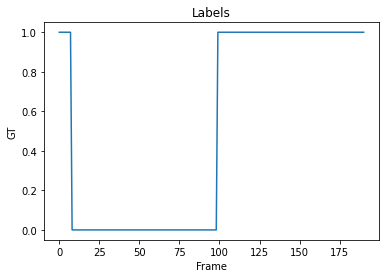

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test023
GT:  23
got model
(200, 227, 227, 1)
got data


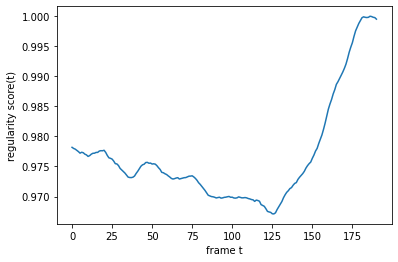

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.9811948858539867
Optimal threshold value is: 0.9811948858539867


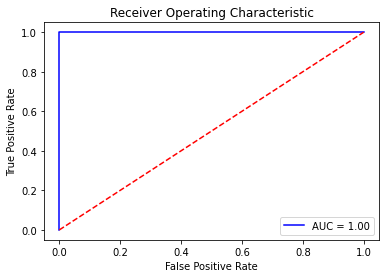

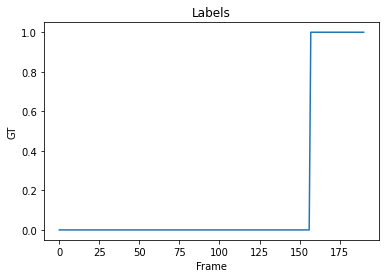

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024
GT:  24
got model
(200, 227, 227, 1)
got data


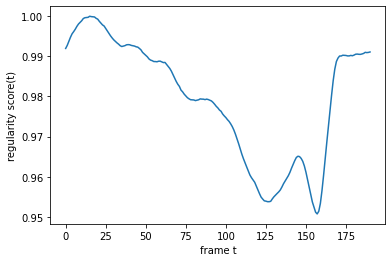

AUC:  0.9409598479448801
EER:  0.09016393442622951
EER THRESHOLD:  0.9895739094008191
Optimal threshold value is: 0.9895739094008191


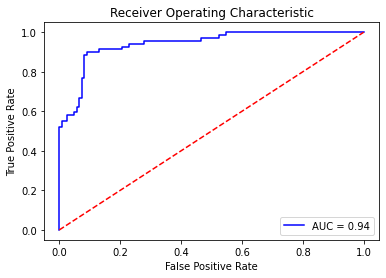

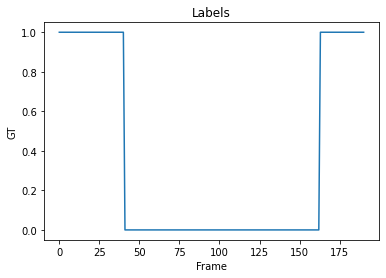

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test025
GT:  25
got model
(200, 227, 227, 1)
got data


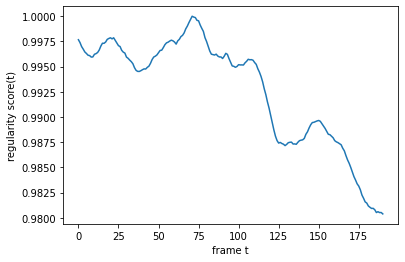

AUC:  0.24155701754385966
EER:  0.4791666666666667
EER THRESHOLD:  0.9959463228848823
Optimal threshold value is: 2.0


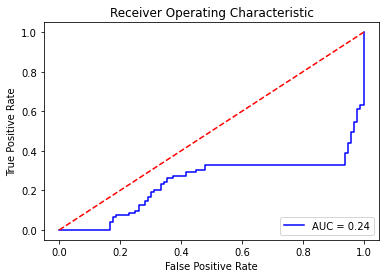

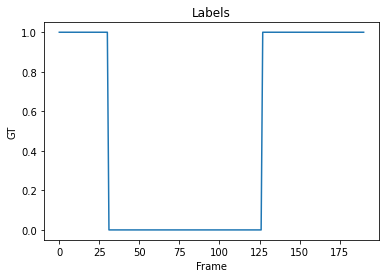

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test026
GT:  26
got model
(200, 227, 227, 1)
got data


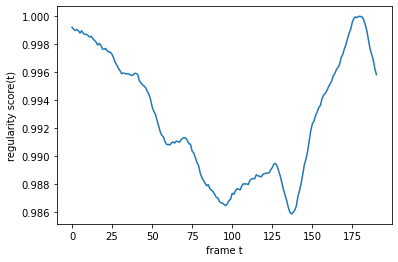

AUC:  0.9306692344727974
EER:  0.08955223880597014
EER THRESHOLD:  0.9907851614574545
Optimal threshold value is: 0.9909204029240108


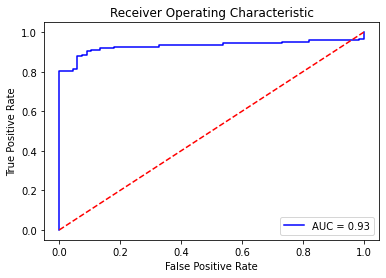

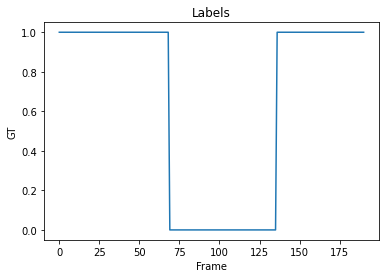

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test027
GT:  27
got model
(200, 227, 227, 1)
got data


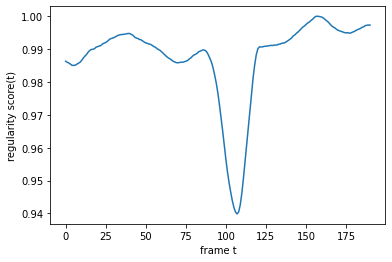

AUC:  0.8557975947356478
EER:  0.26548672566371684
EER THRESHOLD:  0.9915194228022246
Optimal threshold value is: 0.9947984979406236


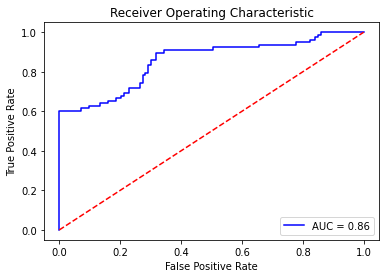

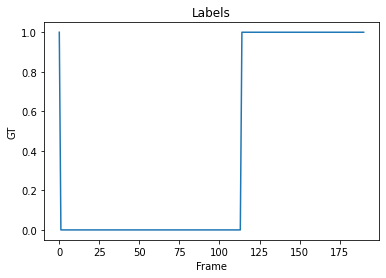

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test028
GT:  28
got model
(200, 227, 227, 1)
got data


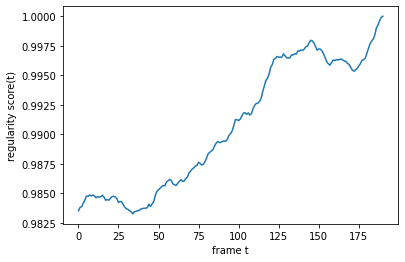

AUC:  0.0
EER:  1.0
EER THRESHOLD:  0.9902996203898919
Optimal threshold value is: 2.0


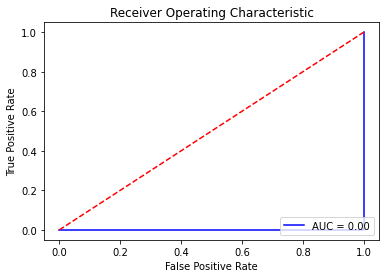

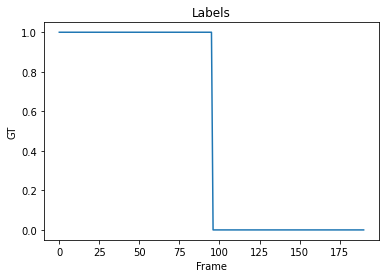

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test029
GT:  29
got model
(200, 227, 227, 1)
got data


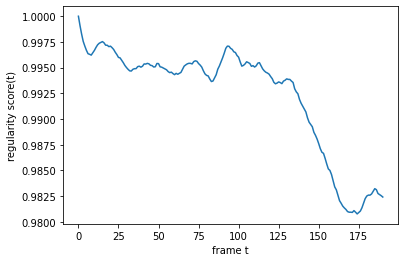

AUC:  0.24382151029748286
EER:  0.7105263157894737
EER THRESHOLD:  0.994904464217343
Optimal threshold value is: 0.9971800478413467


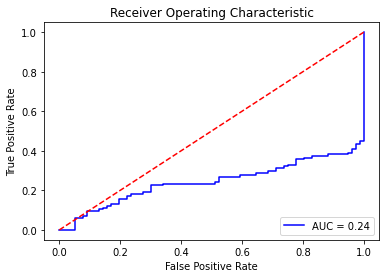

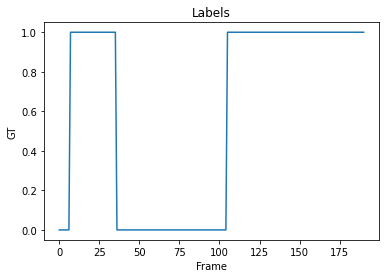

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test030
GT:  30
got model
(200, 227, 227, 1)
got data


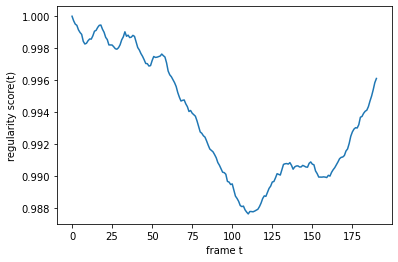

AUC:  0.4761445783132531
EER:  0.48
EER THRESHOLD:  0.9931200708512489
Optimal threshold value is: 0.9962185845343665


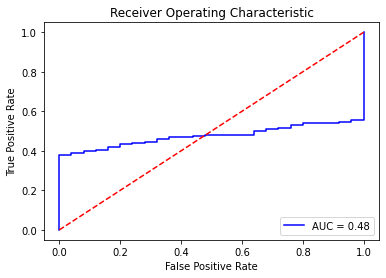

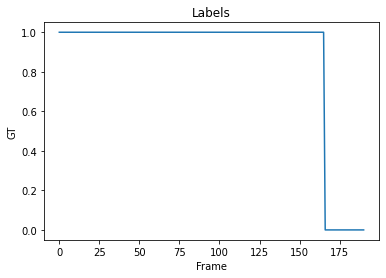

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test031
GT:  31
got model
(200, 227, 227, 1)
got data


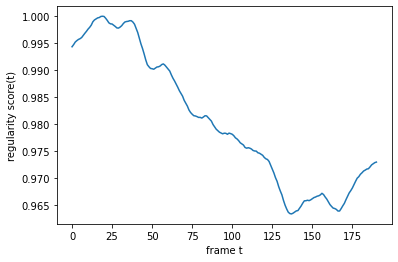

AUC:  0.26070991432068547
EER:  0.7267441860465116
EER THRESHOLD:  0.9724247640801621
Optimal threshold value is: 0.9666916064894348


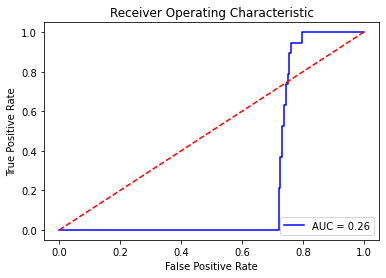

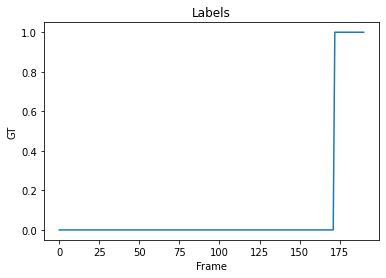

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032
GT:  32
got model
(200, 227, 227, 1)
got data


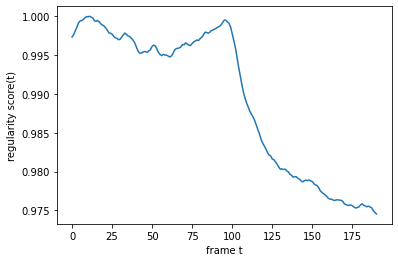

AUC:  0.021271929824561404
EER:  0.8947368421052632
EER THRESHOLD:  0.9950976292890535
Optimal threshold value is: 2.0


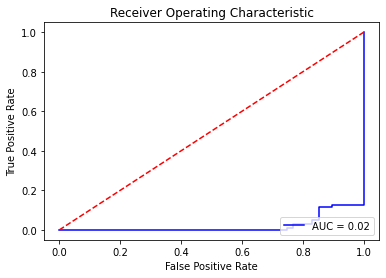

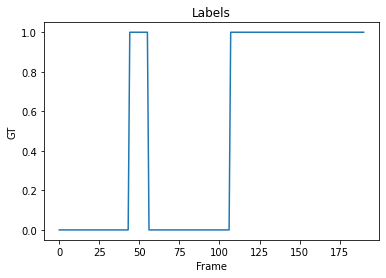

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test033
GT:  33
got model
(200, 227, 227, 1)
got data


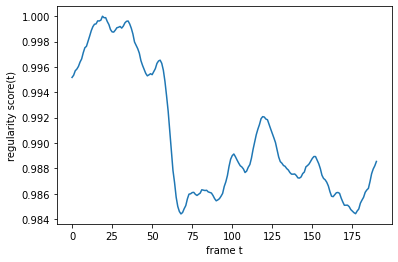

AUC:  0.12532783814162607
EER:  0.7961783439490446
EER THRESHOLD:  0.9869319638317873
Optimal threshold value is: 0.9844201956651223


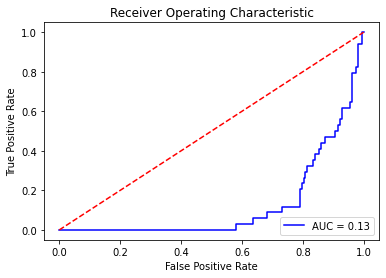

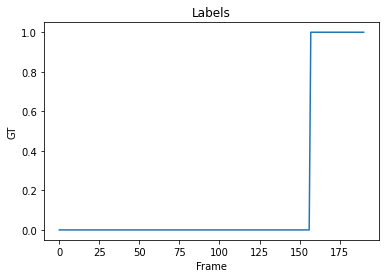

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test034
GT:  34
got model
(200, 227, 227, 1)
got data


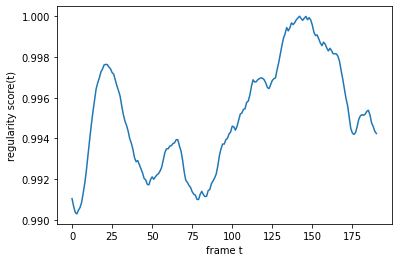

AUC:  0.9087814840027229
EER:  0.21238938053097345
EER THRESHOLD:  0.9953304895562725
Optimal threshold value is: 0.9941964849224201


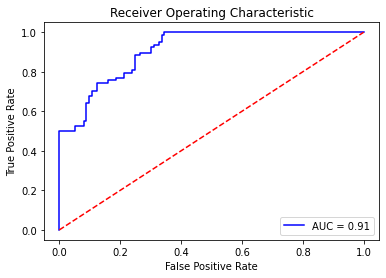

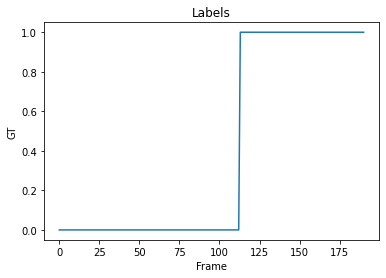

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test035
GT:  35
got model
(200, 227, 227, 1)
got data


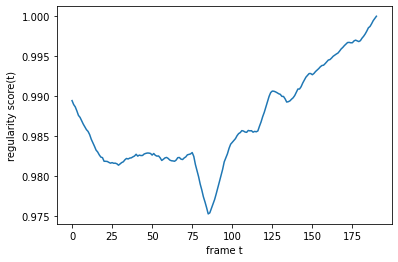

AUC:  0.20141262246525404
EER:  0.8070175438596491
EER THRESHOLD:  0.9837361944188204
Optimal threshold value is: 0.9813665937689471


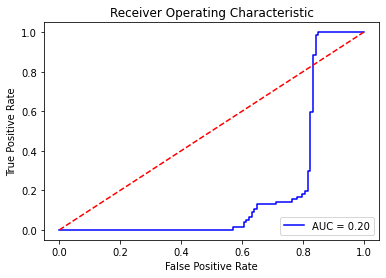

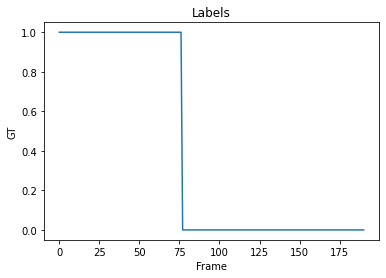

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036
GT:  36
got model
(200, 227, 227, 1)
got data


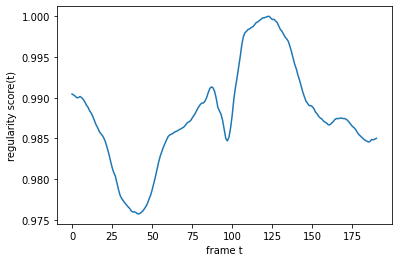

AUC:  0.8241939021715289
EER:  0.2872340425531915
EER THRESHOLD:  0.9872176516417753
Optimal threshold value is: 0.9866826734601879


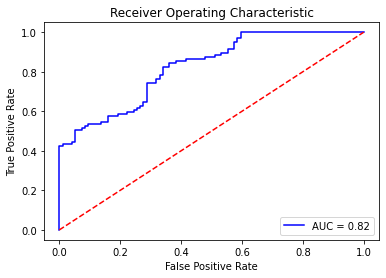

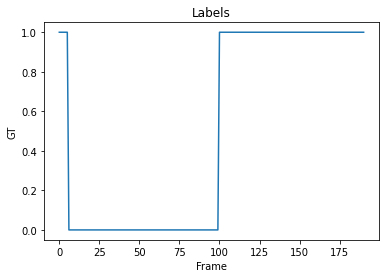

AUC:  0.4892217473980597
EER:  0.5197427667702978


In [12]:
clips = []
# loop over the testing videos to get everysingle one
for f in sorted(listdir(Config.TEST_PATH)):
    if isdir(join(Config.TEST_PATH, f)):
      if not 'gt' in f:
        clips.append(join(Config.TEST_PATH, f))


scores = []

for i in range(len(clips)):
  if(i == 16): #skip clip 17 -> does not work 
    continue

  Config.SINGLE_TEST_PATH = clips[i]
  Config.SINGLE_TEST_VIDEO_FILE = i+1

  print("PATH: ", Config.SINGLE_TEST_PATH)
  print("GT: ", Config.SINGLE_TEST_VIDEO_FILE)

  pr = evaluate()
  scores.append(plotROC(pr))


mean = np.mean(scores, axis=0)   #calculating the mean value of all AUCs and EERs
#print(scores)
print("AUC: ", mean[0])
print("EER: ", mean[1])

In [13]:
"""
#manually counting tp, fp, tn, fn  

#OUTCOME: very similar ROC and AUC, but this manual version would require changing the videos each time by hand

def multiTresh(pr):
    treshMin, treshMax, step=min(pr),max(pr),0.01
    treshold = treshMin
    dif=0
    rangeFrom, rangeTo = 59, 152+1  #range from the TestVideoFile[1]
    rate,pair=[],[]
      

    while(treshold<treshMax):
        treshold = treshold + step
        truePositive, falsePositive, falseNegative, trueNegative = 0,0,0,0 
      
        for ii in range(len(pr)):
            if pr[ii]<treshold and ii in range(rangeFrom, rangeTo):
                truePositive +=1
            if pr[ii]<treshold and ii not in range(rangeFrom, rangeTo):
                falsePositive += 1  
            if pr[ii]>treshold and ii in range(rangeFrom, rangeTo):
                falseNegative +=1
            if pr[ii]>treshold and ii not in range(rangeFrom, rangeTo):
                trueNegative += 1 
        pair=[]
        tpr=truePositive/(truePositive  + falseNegative)
        pair.append(tpr)
        fpr=falsePositive/(trueNegative+ falsePositive )
        pair.append(fpr)
        rate.append(pair)
    return rate


pairs=multiTresh(pr)
for ii in range(len(pairs)):
    print(pairs[ii]) 

roc_point = pairs    
pivot = pd.DataFrame(roc_point, columns = ["x", "y"])
pivot

#ROC
plt.scatter(pivot.y, pivot.x)
plt.plot([0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

#AUC
from numpy import trapz
auc = np.trapz(pivot.x, pivot.y)
auc
"""

'\n#manually counting tp, fp, tn, fn  \n\n#OUTCOME: very similar ROC and AUC, but this manual version would require changing the videos each time by hand\n\ndef multiTresh(pr):\n    treshMin, treshMax, step=min(pr),max(pr),0.01\n    treshold = treshMin\n    dif=0\n    rangeFrom, rangeTo = 59, 152+1  #range from the TestVideoFile[1]\n    rate,pair=[],[]\n      \n\n    while(treshold<treshMax):\n        treshold = treshold + step\n        truePositive, falsePositive, falseNegative, trueNegative = 0,0,0,0 \n      \n        for ii in range(len(pr)):\n            if pr[ii]<treshold and ii in range(rangeFrom, rangeTo):\n                truePositive +=1\n            if pr[ii]<treshold and ii not in range(rangeFrom, rangeTo):\n                falsePositive += 1  \n            if pr[ii]>treshold and ii in range(rangeFrom, rangeTo):\n                falseNegative +=1\n            if pr[ii]>treshold and ii not in range(rangeFrom, rangeTo):\n                trueNegative += 1 \n        pair=[]\n   